# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

In [1]:
#Only needed if running on the quantum device
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
#backend = provider.get_backend('ibmq_jakarta')
backend = provider.get_backend('ibmq_guadalupe')

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [2]:
import numpy as np 

#H = np.load('Hamiltonian_Example.npy')
# I have -2.0 < u 2.0 in steps of 0.1
u=4.0
t=-1
H = np.load('H_mu_'+str(u)+"_t_"+str(t)+'.npy')

In [3]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-2.10274848e+00, -1.80642385e+00, -1.06814039e+00, -8.28427125e-01,
       -8.28427125e-01,  8.70432672e-16,  5.81449281e-01,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.38787313e+00,
        2.96539191e+00,  3.17157288e+00,  3.17157288e+00,  4.00000000e+00,
        4.00000000e+00,  4.00000000e+00,  4.00000000e+00,  4.00000000e+00,
        4.00000000e+00,  4.82842712e+00,  4.82842712e+00,  5.03460809e+00,
        5.61212687e+00,  6.00000000e+00,  6.00000000e+00,  6.00000000e+00,
        6.00000000e+00,  7.41855072e+00,  8.00000000e+00,  8.82842712e+00,
        8.82842712e+00,  9.06814039e+00,  9.80642385e+00,  1.01027485e+01])

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [4]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [5]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [6]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,4.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,8.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,4.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [7]:
print(blocks['0,0'])

SummedOp([
  5.5 * III,
  -0.5 * IIX,
  IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -1.5 * IZI,
  -0.5 * IZX,
  IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -0.5 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [8]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-8-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-8-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [9]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,8,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,4,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,4,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,4,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,4,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,4,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,4,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,8,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [10]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

(-2.1027484834620758+0j)
-2.1027484834620758


## The Anzatz circuit

In [11]:
from qiskit import IBMQ, transpile, schedule, pulse
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder, rzx_templates
from qiskit.transpiler import PassManager

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [12]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))

print("number of qubits:", Q)

number of qubits: 3


I am going to specialize to a three qubit system.  For a general form of the anzatz operator see VQE_2.0 or VQE_Quantum_Grouped_Adjustable.

In [13]:
sys_qs = [2,1,4]
aux_qs = [3,0,7]

In [14]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],sys_qs[q])
    for q in range(0,Q,4):
        cir_i.cx(sys_qs[q],sys_qs[q+1])
        if q + 3 < Q:
            cir_i.cx(sys_qs[q+3],sys_qs[q+2])
    for q in range(1,Q,4):
        cir_i.cx(sys_qs[q],sys_qs[q+1])
        if q + 3 < Q:
            cir_i.cx(sys_qs[q+3],sys_qs[q+2])
    
    return cir_i


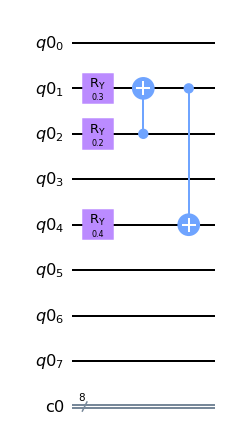

In [15]:
qr = QuantumRegister(8)
cr = ClassicalRegister(8)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [16]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


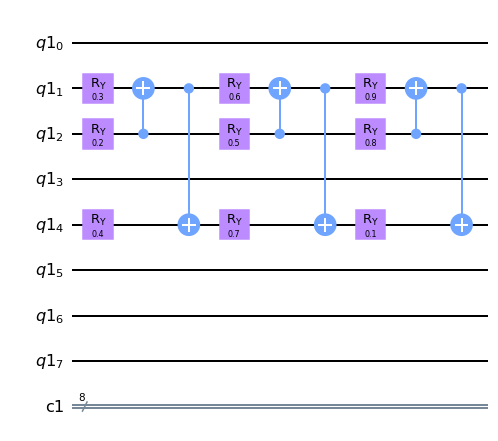

In [17]:
qr = QuantumRegister(8)
cr = ClassicalRegister(8)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

In order to deal with off diagonal blocks, we will also need to form $$ U^{ab} = I\otimes U^a + X \otimes U^b$$

In order to create this gate we need a controled-Ry gate.  The controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

Alternetively, we can build the conrtroled-Ry as $C_{R_y}(\phi) =  R_y(\phi/2) R_z(-\pi/2) R_{zx}(-\phi/2) R_z(\pi/2)$

In [51]:

def Ui_off_old(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],sys_qs[q])
        cir_i.cx(aux_qs[q],sys_qs[q])
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,sys_qs[q])
        cir_i.cx(aux_qs[q],sys_qs[q])
        cir_i.ry((phi_b[q]-phi_a[q])/2,sys_qs[q])
    for q in range(0,Q,4):
        cir_i.cx(sys_qs[q],sys_qs[q+1])
        if q + 3 < Q:
            cir_i.cx(sys_qs[q+3],sys_qs[q+2])
    for q in range(1,Q,4):
        cir_i.cx(sys_qs[q],sys_qs[q+1])
        if q + 3 < Q:
            cir_i.cx(sys_qs[q+3],sys_qs[q+2])
    
    return cir_i

In [52]:
def Ui_off(cir_i,phi_a, phi_b):  
    for q in range(0,Q):
        cir_i.ry(phi_a[q],sys_qs[q])
        cir_i.rz(-np.pi/2,sys_qs[q])
        cir_i.rzx(-(phi_b[q]-phi_a[q])/2,aux_qs[q],sys_qs[q])
        cir_i.rz(np.pi/2,sys_qs[q])
        cir_i.ry((phi_b[q]-phi_a[q])/2,sys_qs[q])
    for q in range(0,Q,4):
        cir_i.cx(sys_qs[q],sys_qs[q+1])
        if q + 3 < Q:
            cir_i.cx(sys_qs[q+3],sys_qs[q+2])
    for q in range(1,Q,4):
        cir_i.cx(sys_qs[q],sys_qs[q+1])
        if q + 3 < Q:
            cir_i.cx(sys_qs[q+3],sys_qs[q+2])
        
    return cir_i

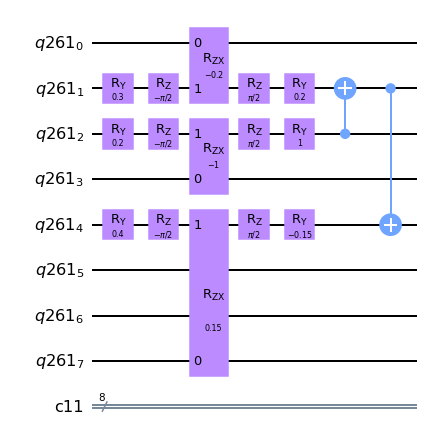

In [53]:
qr = QuantumRegister(8)
cr = ClassicalRegister(8)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])
tst = cir_i

qr = QuantumRegister(8)
cr = ClassicalRegister(8)
cir_i = QuantumCircuit(qr , cr)
tst_old = Ui_off_old(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

In [54]:
psi_tst = qi.Statevector.from_instruction(tst)
psi_tst_old  = qi.Statevector.from_instruction(tst_old)

np.amax(np.abs(psi_tst-psi_tst_old))

1.1102230246251565e-16

Now let us create a function which writes a circuit in terms of the native gates of the backend with Rzx included as a native gate.

In [55]:
def Rzx_Pass(circ):
    native_gates = ['rz', 'sx', 'rzx', 'x','cx']
    pass_ = RZXCalibrationBuilder(backend)
    circ_pile = transpile(circ, backend, basis_gates=native_gates)
    circ_scaled = PassManager(pass_).run(circ_pile)
    return circ_scaled
    
tst_scaled = Rzx_Pass(tst)
tst_old_scaled = Rzx_Pass(tst_old)

psi_tst_scaled  = qi.Statevector.from_instruction(tst_scaled)
psi_tst_old_scaled  = qi.Statevector.from_instruction(tst_old_scaled)

np.amax(np.abs(psi_tst_scaled-psi_tst_old_scaled))

5.968147606573047e-16

In [56]:
tst_sched = schedule(tst_scaled, backend)
tst_old_sched = schedule(tst_old_scaled, backend)

print('Scaled schedule takes '+str(tst_sched.duration)+'dt')
print('Digital schedule takes '+str(tst_old_sched.duration)+'dt')

Scaled schedule takes 6016dt
Digital schedule takes 9088dt


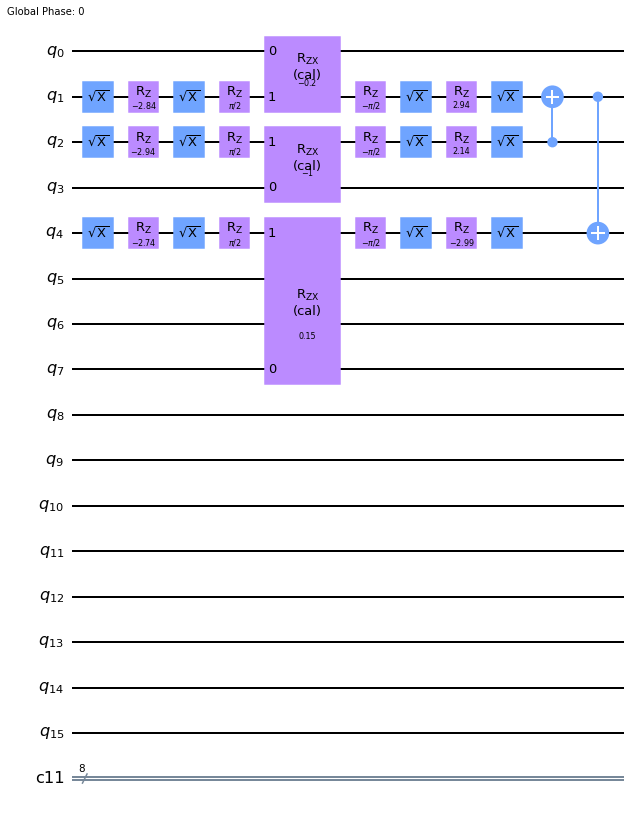

In [57]:
tst_scaled.draw(output = "mpl")


ISSUE: for non-sequential qubits coupled by Rzx gates, the transpiler is freaking out.  Plan: switch to guadalupe and use 1,2,3 for the system and 0,3,7 as auxiliary qubits.  This works.  FIXED 

Now we I need to check that using three auxiliary qubits instead of one still gives the same energy results.  

In [58]:
#tst_sched.draw()

In [59]:
#tst_old_sched.draw()

Let's check to make sure we are generating the right thing

In [60]:
#An example block a circuit
qr = QuantumRegister(8)
cr = ClassicalRegister(8)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(8)
cr = ClassicalRegister(8)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(8)
cr = ClassicalRegister(8)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(aux_qs[0])
cir_i.h(aux_qs[1])
cir_i.h(aux_qs[2])
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])
#tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[0.2,0.3,0.4])

print('A:')
print(1/np.sqrt(8)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(8)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
psi_AB = qi.Statevector.from_instruction(tst_off).data
psi_ABp = 1/4*Mdot([I(8) + Mdot([Z(0,8),Z(3,8)]) + Mdot([Z(0,8),Z(7,8)]) + Mdot([Z(3,8),Z(7,8)]) ,psi_AB])
print(psi_ABp)

A:
[0.34090333+0.j 0.        +0.j 0.01044413+0.j 0.        +0.j
 0.00516949+0.j 0.        +0.j 0.00693358+0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.06910453+0.j 0.        +0.j 0.0515225 +0.j 0.        +0.j
 0.00104791+0.j 0.        +0.j 0.03420442+0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.   

Issue: we are generating the state $$|\psi> = (U(\phi_a)|000> + U(\phi_b)|111> + junk (|011> + ...))\otimes |\psi_s>$$

We can resolve this by doing a projective measurement:
$$ <\psi|X_0X_1X_2(|000><000| + |111><111|)|\psi> =  <\psi|X_0X_1X_2(1+Z_0Z_1+ Z_0Z_2+Z_1Z_2)|\psi> = <\psi_s|U^{\dagger}(\phi_b)U(\phi_a)|\psi_s>$$

In [61]:
import qiskit.quantum_info as qi

def I(N):
    label = ['I' for i in range(N)]
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def X(i,N):
    label = ['I' for i in range(N)]
    label[N-i-1] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[N-i-1] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[N-i-1] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])

psi_A = qi.Statevector.from_instruction(tst_a).data
psi_B = qi.Statevector.from_instruction(tst_b).data

psi_AB = qi.Statevector.from_instruction(tst_off).data
psi_ABp = 1/4*Mdot([I(8) + Mdot([Z(0,8),Z(3,8)]) + Mdot([Z(0,8),Z(7,8)]) + Mdot([Z(3,8),Z(7,8)]) ,psi_AB])


print(bkt(psi_B,I(8),psi_A))
print(1/2*8*bkt(psi_ABp,Mdot([X(0,8),X(3,8),X(7,8)]),psi_ABp))
print(bkt(psi_AB,Mdot([X(0,8),X(3,8),X(7,8)]) - Mdot([Y(0,8),Y(3,8),X(7,8)]) - Mdot([Y(0,8),X(3,8),Y(7,8)]) - Mdot([X(0,8),Y(3,8),Y(7,8)]),psi_AB))


(0.5235861557494269+0j)
(0.523586155749427+0j)
(0.523586155749427+0j)


In [105]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(aux_qs[0])
    cir.h(aux_qs[1])
    cir.h(aux_qs[2])
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

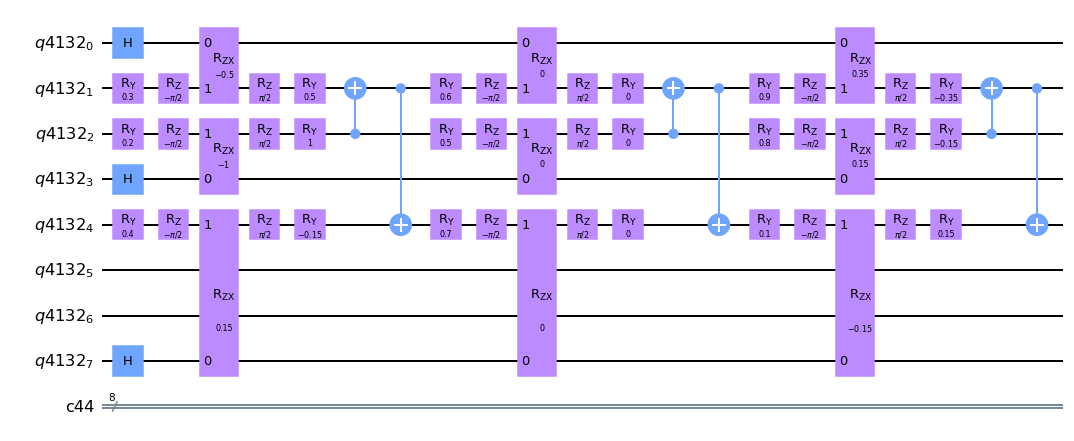

In [106]:
qr = QuantumRegister(8)
cr = ClassicalRegister(8)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

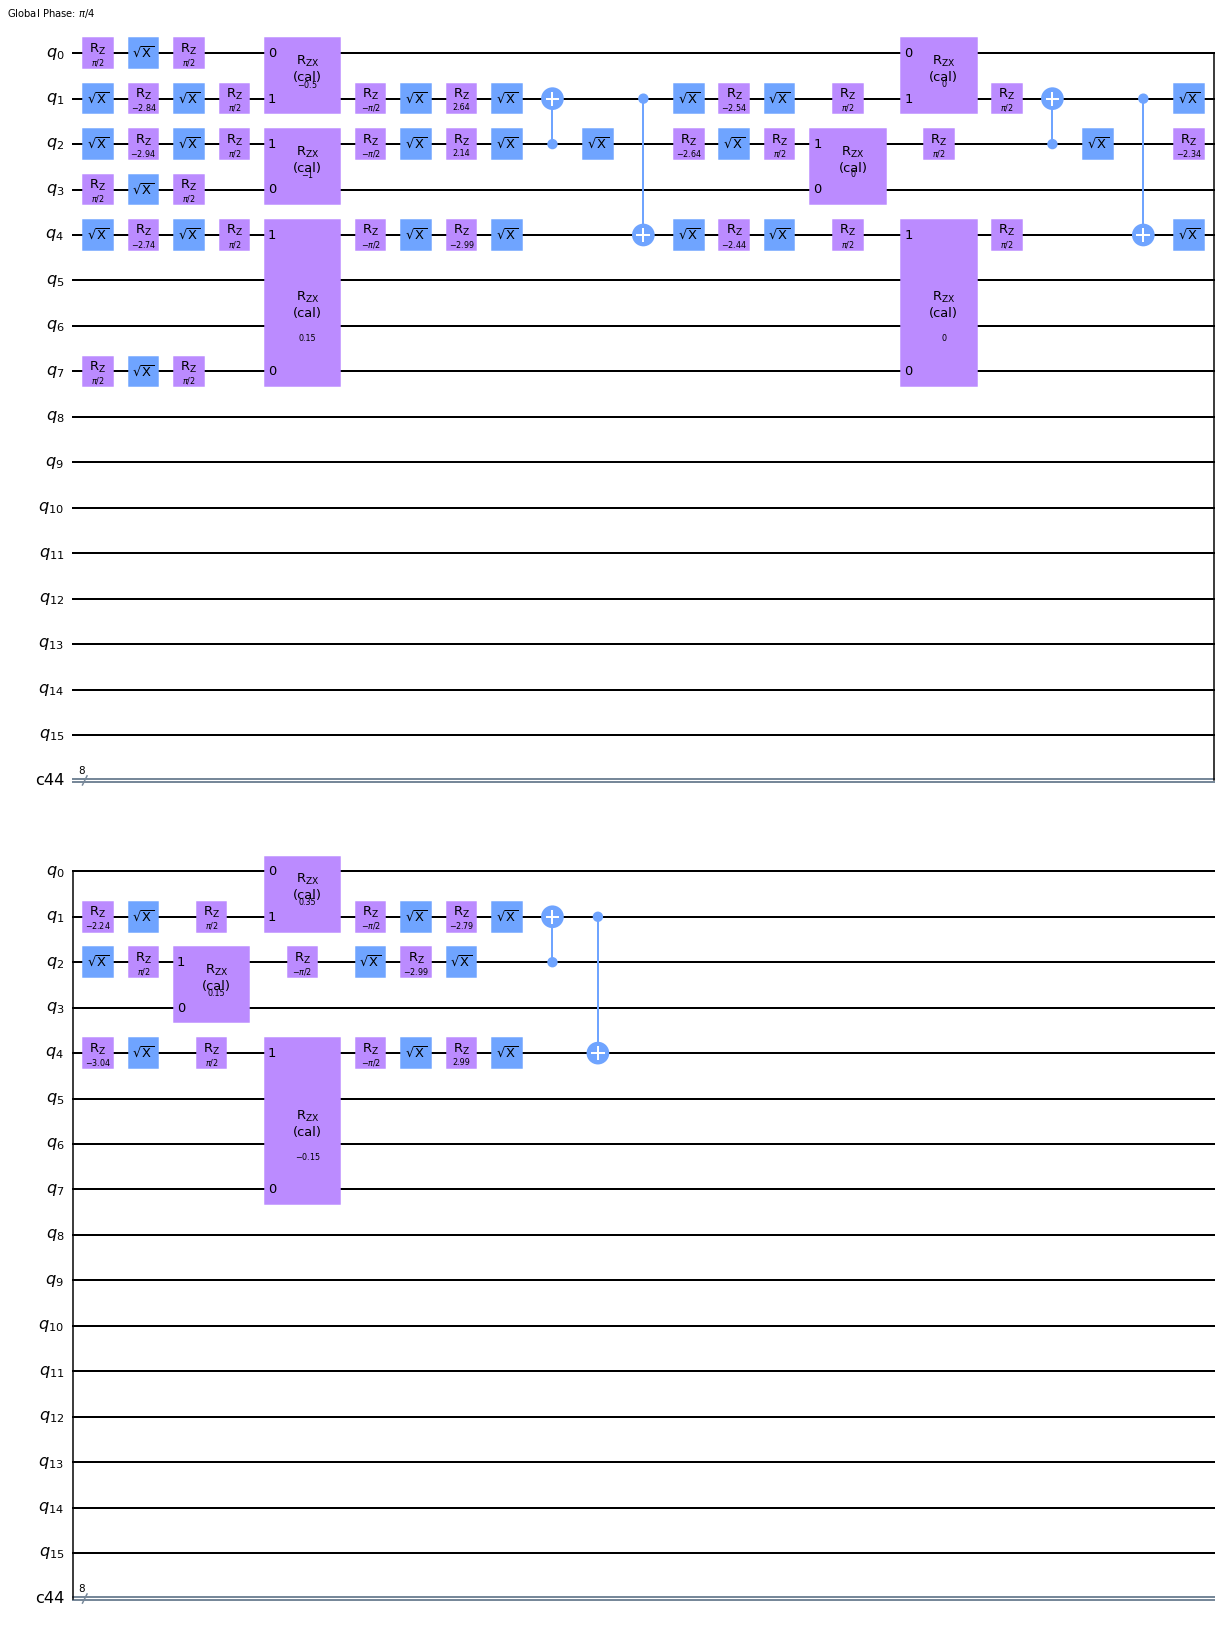

In [107]:
tst_scaled = Rzx_Pass(tst)

tst_scaled.draw(output='mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



### Stratagy

In order to run on the quantum device, I would like to group together all of the runs so that each time I measure energy, I only have to que once.  

1) We prepare the circuit to be measured for a given p_label and include measurment instructions.  

2) We collect all of the p_labels from a block into a circuit array

3) We collect all of the blocks into a circuit array

4) we send to the backend

5) we use the measurment instructions to decode the results

6) sum everything together to get the energy

### Prepare the circuits

This is where I left off.

In [108]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

IIX
[0, 0, 1]


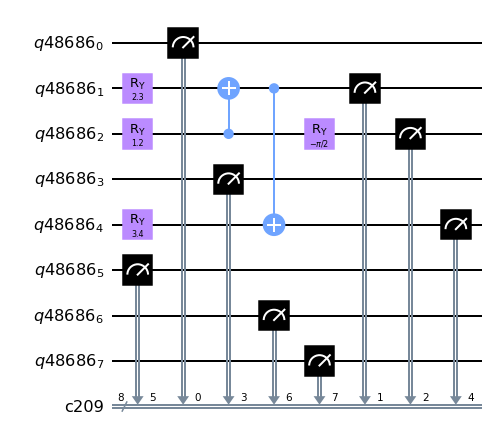

In [180]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def convert_to_circ(p_label,psi0):
    all_qs = sys_qs + aux_qs
    #apply rotations
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,all_qs[Q-1-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,all_qs[Q-1-q])
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'       
    #apply measurment 
    psi.measure(psi.qubits,psi.clbits)
    #psi.measure(sys_qs,sys_qs)
    #return circut and measurement instructions
    return [psi,pauli_qs]


#Run a test
import copy
qr = QuantumRegister(8)
cr = ClassicalRegister(8)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][1].primitive.to_label()
        
    
cir_tst, lab_tst =  convert_to_circ(p_label,psi0) 
print(p_label)
print(lab_tst)
cir_tst.draw(output = "mpl")

### Collect the circuits 

-0.5
[0, 0, 1]


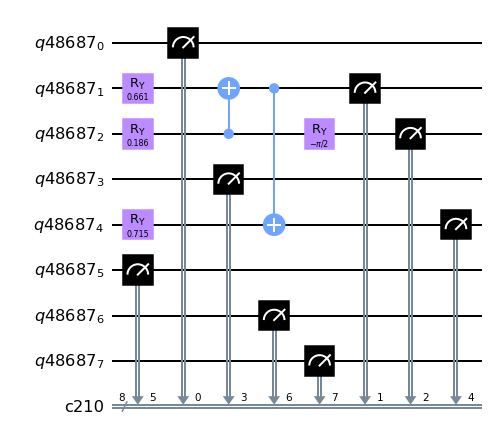

In [181]:
#This collects the circuits for the on-diagonal blocks only
def collect_diag_circs(phi_b,block):
    qr = QuantumRegister(8)
    cr = ClassicalRegister(8)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    cirs = []
    meas = []
    coef = []
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        if np.abs(w) > 0:
            p_label = p.primitive.to_label()
            cir_p,meas_p  = convert_to_circ(p_label,psi)
            cirs.append(cir_p)
            meas.append(meas_p)
            coef.append(w)
    return cirs,meas,coef

block = blocks['0,0']
phi_b = phi[0]

circs, meas, coefs = collect_diag_circs(phi_b,block)

n=1
print(coefs[n])
print(meas[n])
circs[n].draw(output = "mpl")

0.125
[1, 1, 1, 1, 0, 0]


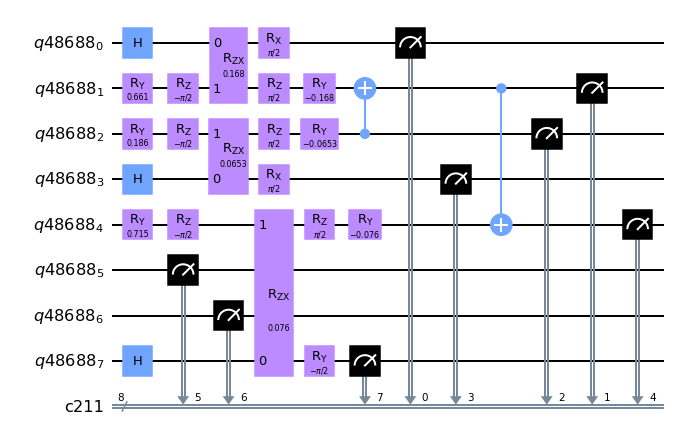

In [182]:
X_projectors = ["XXX",'YYX','YXY','XYY']
X_coefs = [1/2,-1/2,-1/2,-1/2]
Y_projectors = ["YYY","XXY","XYX","YXX"]
Y_coefs = [-1j/2,1j/2,1j/2,1j/2]

# This collects circuits for both on and off diagonal blocks but is unefficient for on-diagonal blocks
def collect_off_circs(phi_a,phi_b,block):
    qr = QuantumRegister(8)
    cr = ClassicalRegister(8)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    cirs = []
    meas = []
    coef = []
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        if np.abs(w) > 0.0:
            p_label = p.primitive.to_label()
            for pj in range(4):
                #"XXX projections"
                circ_x,meas_x = convert_to_circ(X_projectors[pj] + p_label,psi)
                cirs.append(circ_x)
                meas.append(meas_x)
                coef.append(X_coefs[pj]*w)
                #"YYY prjoections"
                circ_y,meas_y = convert_to_circ(Y_projectors[pj] + p_label,psi)
                cirs.append(circ_y)
                meas.append(meas_y)
                coef.append(Y_coefs[pj]*w)
    return cirs,meas,coef


block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]

circs, meas, coefs = collect_off_circs(phi_a,phi_b,block)

n=22
print(coefs[n])
print(meas[n])
circs[n].draw(output = "mpl")

416
-0.12500000000000003j
[1, 1, 1, 0, 0, 0]


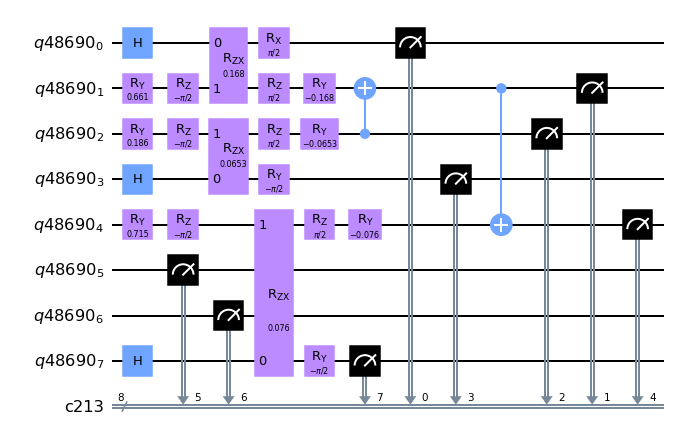

In [183]:
# collect all the circuits 
# The off diagonal coefs are doubled to take care of the Hermition conjugate
def collect_circs(alpha,phi,blocks):
    circs = []
    meas = []
    coefs = []
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            circ_b, meas_b, coef_b = collect_diag_circs(phi[int(key[0])],blocks[key])
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
        else:
            circ_b, meas_b, coef_b = collect_off_circs(phi[int(key[0])],phi[int(key[2])],blocks[key])
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(2*alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
    return circs, meas, coefs

circs, meas, coefs = collect_circs(alpha,phi,blocks)

n=31
print(len(circs))
print(coefs[n])
print(meas[n])
circs[n].draw(output = 'mpl')

### Run function

First let us pass all or our circuits throught the Rzx_pass filter.  

cicrs_pass will be the master list of circuits to be run during each iteration.

In [184]:
circs, meas, coefs = collect_circs(alpha,phi,blocks)
circs_pass = Rzx_Pass(circs)


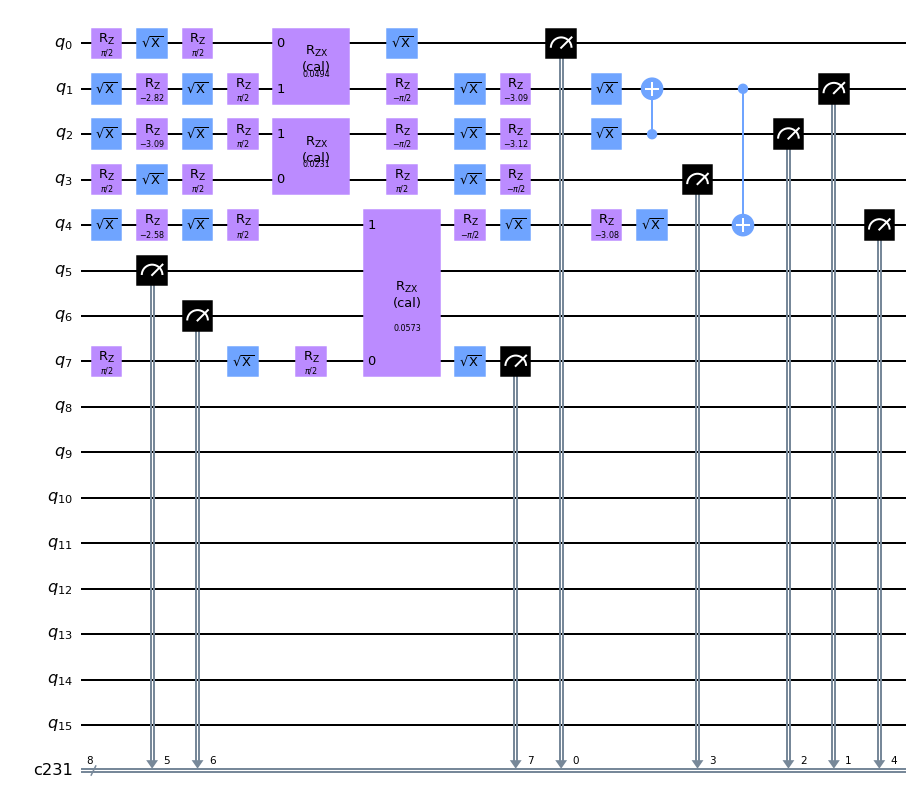

In [185]:
circs_pass[150].draw(output = 'mpl')

In [186]:
#circs, meas, coefs = collect_circs(alpha,phi,blocks)

def get_results(circs, method = 'matrix',save_id_file = None):
    if method == 'matrix':
        # add results
        r = []
        for l in range(len(circs_pass)):
            circs_pass[l].remove_final_measurements()
            wave = qi.Statevector.from_instruction(circs_pass[l])
            r_l = wave.probabilities_dict()
            r.append(r_l)
    
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        r = execute(circs_pass, backend = sim).result().get_counts()
        
    if method == "quantum":
        job = backend.run(transpile(circs_pass, backend), meas_level=2, shots=8192)
        job_id = job.job_id()
        print(job_id)
        np.save(save_id_file,[job_id])
        r = job.result().get_counts()
        
        
    return r

r = get_results(circs, method = 'matrix')
#r = get_results(circs, method = 'simulator')
#r = get_results(circs, method = 'quantum')

### Stopping point.  

Issue: meas only lists the logical qubits while key lists all qubits in the system.  This is a problem when I am trying to compare the ket and meas in the next section.

Consider only measuring the logical qubits.  There is a commented out version of the measurements which does this but I am unsure how this affects the auxiliary qubits.  

### Analyze results

In [145]:
def energy_from_results(r,meas,coefs):
    E = 0
    for l in range(len(r)):
        z_measure = 0
        total = 0
        for key in list(r[l].keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and meas[l][q] == 1:
                    n += 1
            z_measure += (-1)**n * r[l][key] 
            total += r[l][key]
        E += coefs[l]*z_measure/total
    return np.real(E)

energy_from_results(r,meas,coefs)

IndexError: list index out of range

In [134]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(4.03900601059125+0j)

In [138]:
#Set alpha and phi to initial value

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
circs, meas, coefs = collect_circs(alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
energy_from_results(r,meas,coefs)

2.6666666666666683

### Grouping three energies to be run together

In the optimization below we use three energies at each step.  One for the current values and two to define the derivetive.  Since the bottle neck is sending jobs to the device, it will be useful to group these three energies into one job.

In [139]:
def collect_energy_circs(a1, p1, b1, a2, p2, b2, a3, p3, b3):
    circs1, meas1, coefs1 = collect_circs(a1,p1,b1)
    circs2, meas2, coefs2 = collect_circs(a2,p2,b2)
    circs3, meas3, coefs3 = collect_circs(a3,p3,b3)
    L1 = len(circs1)
    L2 = len(circs2)
    L3 = len(circs3)
    circs = circs1+circs2+circs3
    meas = meas1+meas2+meas3
    coefs = coefs1+coefs2+coefs3
    lengths = [L1,L2,L3]
    return circs,meas,coefs,lengths

def three_energies_from_results(r,meas,coefs,lengths):
    L1 = lengths[0]
    L2 = lengths[1]
    L3 = lengths[2]
    r1 = r[0 : L1]
    r2 = r[L1 : L1+L2]
    r3 = r[L1+L2 : L1+L2+L3]
    m1 = meas[0 : L1]
    m2 = meas[L1 : L1+L2]
    m3 = meas[L1+L2 : L1+L2+L3]
    c1 = coefs[0 : L1]
    c2 = coefs[L1 : L1+L2]
    c3 = coefs[L1+L2 : L1+L2+L3]
    E1 = energy_from_results(r1,m1,c1)
    E2 = energy_from_results(r2,m2,c2)
    E3 = energy_from_results(r3,m3,c3)
    return E1,E2,E3
    

In [140]:
circs, meas, coefs, lengths = collect_energy_circs(alpha,phi,blocks,alpha,phi,blocks,alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
E1,E2,E3 = three_energies_from_results(r,meas,coefs,lengths)
print(E1,E2,E3)

2.6666666666666683 2.6666666666666683 2.6666666666666683


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [141]:
import copy
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

In [153]:
tt = t

def SPSA(k_max,method = 'simple', group = False ,hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
           
        #Find E    
        if group:
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs,meas,coefs,lengths = collect_energy_circs(alpha_k_A,phi_k_A,blocks,alpha_k_B,phi_k_B,blocks,alpha_k,phi_k,blocks)
            r = get_results(circs, method = method,save_id_file = save_id_file)
            E_Ap, E_Bp, E_fp = three_energies_from_results(r,meas,coefs,lengths)
        else:
            #A
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            print(tt)
            print(save_id_file)
            circs_A, meas_A, coefs_A = collect_circs(alpha_k_A,phi_k_A,blocks)
            r_A = get_results(circs_A, method = method,save_id_file = save_id_file)
            E_A = energy_from_results(r_A,meas_A,coefs_A)
            #B
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobB_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_B, meas_B, coefs_B = collect_circs(alpha_k_B,phi_k_B,blocks)
            r_B = get_results(circs_B, method = method,save_id_file = save_id_file)
            E_B = energy_from_results(r_B,meas_B,coefs_B)
            #f
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobf_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_f, meas_f, coefs_f = collect_circs(alpha_k,phi_k,blocks)
            r_f = get_results(circs_f, method = method,save_id_file = save_id_file)
            E_f = energy_from_results(r_f,meas_f,coefs_f)

        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Print and save E
        print(k,E_f)
        #print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            np.save("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u),[hold_k])
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [154]:
out = SPSA(1,method = 'quantum',hold = True)

-1
/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_0_T_1_A_10_a_0.05_c_0.4_beta_0.201_gamma_0.101_t_-1_u_4.0
61f215db4ddc9f427380ff1e
61f21852404aae5bbf43ad30
61f21a65ded89e4093aa0fef
0 3.5290323893229183


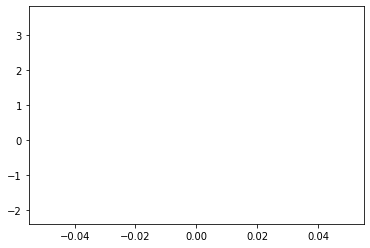

In [155]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [157]:
k=0
job_id = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy")
job_info = backend.retrieve_job(job_id[0])
hold = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy",allow_pickle=True)
            

In [158]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

tt = t

def SPSA_from_load(k_min,k_max,load,method = 'simple', group = False ,hold = False):
    #Initalization
    k = 0
    phi_k = load['phi']
    alpha_k = load['alpha']
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_min,k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
           
        #Find E    
        if group:
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/job_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs,meas,coefs,lengths = collect_energy_circs(alpha_k_A,phi_k_A,blocks,alpha_k_B,phi_k_B,blocks,alpha_k,phi_k,blocks)
            r = get_results(circs, method = method,save_id_file = save_id_file)
            E_Ap, E_Bp, E_fp = three_energies_from_results(r,meas,coefs,lengths)
        else:
            #A
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_A, meas_A, coefs_A = collect_circs(alpha_k_A,phi_k_A,blocks)
            r_A = get_results(circs_A, method = method,save_id_file = save_id_file)
            E_A = energy_from_results(r_A,meas_A,coefs_A)
            #B
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobB_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_B, meas_B, coefs_B = collect_circs(alpha_k_B,phi_k_B,blocks)
            r_B = get_results(circs_B, method = method,save_id_file = save_id_file)
            E_B = energy_from_results(r_B,meas_B,coefs_B)
            #f
            save_id_file = "/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobf_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u)
            circs_f, meas_f, coefs_f = collect_circs(alpha_k,phi_k,blocks)
            r_f = get_results(circs_f, method = method,save_id_file = save_id_file)
            E_f = energy_from_results(r_f,meas_f,coefs_f)

        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Print and save E
        print(k,E_f)
        #print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            np.save("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(tt)+"_u_"+str(u),[hold_k])
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [159]:
out = SPSA_from_load(1,200,hold[0],method = 'quantum',hold = True)

61f2a92fdfe4a9946e230926
61f2ac15dfe4a937cf230934
61f2c6c4dfe4a9ce9c2309d2
1 3.4969336806628863
61f2c8feded89e3fb7aa14d5
61f2cb1cded89e38f4aa14ea
61f2cd40ded89eed9daa14f7
2 3.241128097423912
61f2cfe0d6c095ae16dfdd05
61f2d1f1ded89e7a17aa150c
61f2d4024ddc9f2ddc810441
3 2.8577246564337493
61f2d60adfe4a9cd7f230a1b
61f2d81f1faa06a00a348b5b
61f2da63dfe4a900d1230a25
4 2.3440330911100493
61f2dc7d9847b31c27ab3cc1
61f2df096fb7973f2b44531b
61f2e11bded89ec5bcaa155b
5 2.1823634699773997
61f2e356404aae856643b2c7
61f2e5fcdfe4a904e5230a56
61f2e8b74ddc9f5c8b81049e
6 2.5075937281640504
61f2eb914eebda0f2d7ab8f4
61f2eda39847b36446ab3d23
61f2eff2ded89e8dceaa159d
7 2.6554182294661794
61f2f2286fb797cf37445367
61f2f4ca4eebda4b647ab91d
61f2f9019847b3297dab3d68
8 1.9784544112009643
61f2fb2e4eebda124c7ab94e
61f2fd439847b33482ab3d75
61f3000bded89e76e2aa15f7
9 2.90741639454792
61f3021b1faa06e82a348c16
61f305964ddc9fb9bf810532
61f308bd6fb7974f944453ee
10 2.2354017905625607
61f30b7c404aae70a043b38f
61f30da14eebdad78

61f5dcb87f4bf849f7bd953b
85 0.05066214861308105
61f5dee84ddc9f10e9811cff
61f5e0f1dfe4a98bf3232307
61f5e3034ddc9fcd73811d14
86 0.35213045274206056
61f5e5189847b3256dab5607
61f5e7286fb7976525446c42
61f5e9397f4bf861f9bd958b
87 0.28431564425380096
61f5eb4a9847b30b58ab5623
61f5ed67ded89e09bfaa2eb1
61f5ef79404aae5f5543cc51
88 0.14441377851324794
61f5f1bdded89e96a7aa2ec7
61f5f3c5dfe4a9ef9b23237f
61f5f601dfe4a91e91232395
89 0.14530935032202913
61f5f8261faa063a4634a487
61f5fa38dfe4a91cbf2323b2
61f5fc3f404aae311a43ccb0
90 0.20462056435069068
61f5fe664eebdabb2a7ad288
61f60077ded89e2c38aa2f35
61f6027fd6c0952633dff6d4
91 -0.0908576933668066
61f60488ded89e61b9aa2f58
61f606a34eebda6f497ad2db
61f608b64ddc9f7abd811e0e
92 0.20976690761000522
61f60af04eebda80197ad2ff
61f60d5c6fb797357a446d4f
61f60f686fb7976776446d65
93 0.38387272126764005
61f61177ded89e06bbaa2fba
61f6138b7f4bf8e6bfbd96c9
61f615d6d6c0952689dff75a
94 0.21125931581625265
61f617dfdfe4a9d581232496
61f61a18404aaeedb243cd7f
61f61c48ded89eb606aa

IBMQJobInvalidStateError: 'Unable to retrieve result for job 61f7683e404aae60cf43d422. Job was cancelled.'

/opt/miniconda3/envs/qiskit_25/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


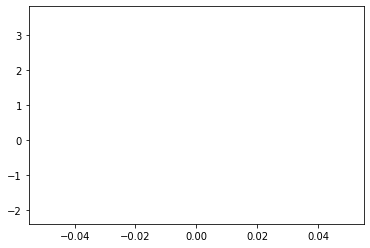

In [160]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [161]:
import numpy as np
El = []
kl = []
out = []
for k in range(0,127):
    job_id = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/jobA_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy")
    job_info = backend.retrieve_job(job_id[0])
    hold = np.load("/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Job_id/run_"+str(k)+'_T_'+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".npy",allow_pickle=True)
    out.append(hold[0])
    El.append(hold[0]['E'])
    kl.append(k)

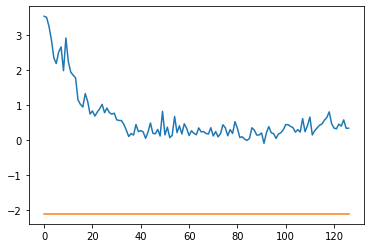

In [162]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(El))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

# Save Data

In [80]:
import pickle
fpath = '/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Data/'

file_to_store = open(fpath + "VQE_jakarta_T_"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [81]:
import pickle
fpath = '/Users/stenger/Documents/Research/Hubbard_symmetries/VQE/Data/'

file_to_read = open(fpath + "VQE_jakarta_T_"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

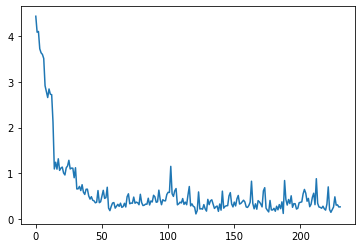

In [82]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)